This references the following

https://github.com/dmlc/mxnet/blob/master/example/multi-task/example_multi_task.py

In [1]:
import numpy as np
import pandas as pd
import mxnet as mx

In [2]:
num_train = 10
num_batch = 3
num_cls   = 5

In [3]:
# input
x1 = np.zeros((num_train, 1, 8, 8))
x2 = np.zeros((num_train, 1, 16, 32))
x3 = np.zeros((num_train, 10))
print((x1.shape, x2.shape, x3.shape))

((10, 1, 8, 8), (10, 1, 16, 32), (10, 10))


In [4]:
# output
y = np.zeros((num_train, num_cls))
print(y.shape)

(10, 5)


In [5]:
# output(multi-task form)
z = [y[:,ii] for ii in range(y.shape[1])]
print(len(z))

5


In [6]:
# official DataIter
mx_dat0 = mx.io.NDArrayIter(
    data=[x1, x2, x3],
    label=z,
    batch_size=num_batch
)
print(mx_dat0.provide_data)
print(mx_dat0.provide_label)

[('_0_data', (3, 1, 8, 8)), ('_1_data', (3, 1, 16, 32)), ('_2_data', (3, 10))]
[('_0_softmax_label', (3,)), ('_1_softmax_label', (3,)), ('_2_softmax_label', (3,)), ('_3_softmax_label', (3,)), ('_4_softmax_label', (3,))]


In [7]:
# custom DataIter
class mx_DataIter(mx.io.NDArrayIter):
    def __init__(self, data, label=None,
                 batch_size=1, shuffle=False, last_batch_handle='pad'):
        super(mx_DataIter, self).__init__(
            data, label,
            batch_size, shuffle, last_batch_handle)
        self.data_name = None
        self.label_name = None
    def set_name(self, data_name, label_name):
        self.data_name = data_name
        self.label_name = label_name
    @property
    def provide_data(self):
        return [
            (self.data_name[ii],
             tuple([self.batch_size] + list(self.data[ii][1].shape[1:])))
            for ii in range(len(self.data))
        ]
    @property
    def provide_label(self):
        return [
            (self.label_name[ii],
             tuple([self.batch_size] + list(self.label[ii][1].shape[1:])))
            for ii in range(len(self.label))
        ]

In [8]:
mx_dat1 = mx_DataIter(
    data=[x1, x2, x3],
    label=z,
    batch_size=num_batch
)
mx_dat1.set_name(
    ['input'+str(ii) for ii in range(3)],
    ['clf'+str(ii)+'_label' for ii in range(num_cls)]
)
print(mx_dat1.provide_data)
print(mx_dat1.provide_label)

[('input0', (3, 1, 8, 8)), ('input1', (3, 1, 16, 32)), ('input2', (3, 10))]
[('clf0_label', (3,)), ('clf1_label', (3,)), ('clf2_label', (3,)), ('clf3_label', (3,)), ('clf4_label', (3,))]


In [9]:
# network
data0 = mx.sym.Variable('input0')
data1 = mx.sym.Variable('input1')
data2 = mx.sym.Variable('input2')
def get_symbol(sym, prefix=''):
    net = mx.sym.BatchNorm(sym,
                           name=prefix+'_bn')
    net = mx.sym.FullyConnected(net,
                                name=prefix+'_fc',
                                num_hidden=3)
    return net
net0 = mx.sym.Flatten(data0)
net1 = mx.sym.Flatten(data1)
net2 = get_symbol(data2, 'i2')
netc  = mx.sym.Concat(*[net0, net1, net2])
fc   = []
out  = []
for ii in range(num_cls):
    fc.append(mx.sym.FullyConnected(netc,
                                    name='fc'+str(ii),
                                    num_hidden=2))
    out.append(mx.sym.SoftmaxOutput(fc[ii],
                                    name='clf'+str(ii)))
net = mx.sym.Group(out)

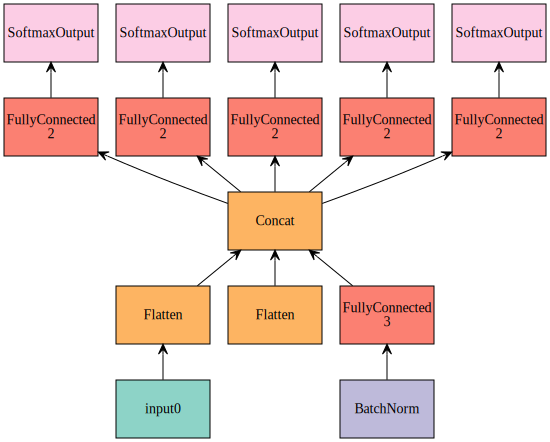

In [10]:
mx.visualization.plot_network(net)

In [11]:
model = mx.model.FeedForward.create(
    net,
    X=mx_dat1,
    num_epoch=10,
)